In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, gamma, beta, chi2
from sklearn.mixture import GaussianMixture
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
#read in the raw data and immediately remove non balls in play

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw19.csv')
raw19 = raw19.loc[raw19['type'] == 'X']

raw18= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw18.csv')
raw18 = raw18.loc[raw18['type'] == 'X']

In [3]:
#combine
all_data = pd.concat((raw22, raw21, raw20, raw19, raw18))

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

del raw22
del raw21
del raw20
del raw19
del raw18

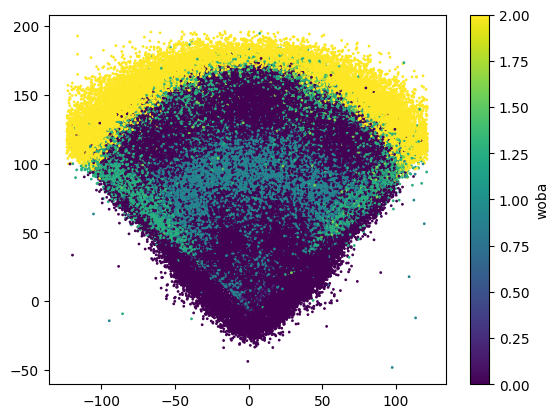

In [4]:
#transform the hc_x and hc_y coordinates so the origin is home plate, as Albert does here https://baseballwithr.wordpress.com/2018/01/15/chance-of-hit-as-function-of-launch-angle-exit-velocity-and-spray-angle/
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values

#plot
plt.scatter(all_data.x.values, all_data.y.values, s=1,c=all_data.woba_value.values)
plt.colorbar(label = 'woba')
plt.show()

In [5]:
#now we can calculate spray angle
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

In [6]:
# we need a distribution for p(hit direction, launch angle, exit speed). If they are independent, then this is easy, we just model each separately. So let's see if they are independent. First, is launch angle independent of
#hit direction.

#scale hit direction by -1 for lefties so we can consider them all at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

In [7]:
#remove extreme angles
all_data = all_data.loc[np.abs(all_data.hit_direction) <= 55]

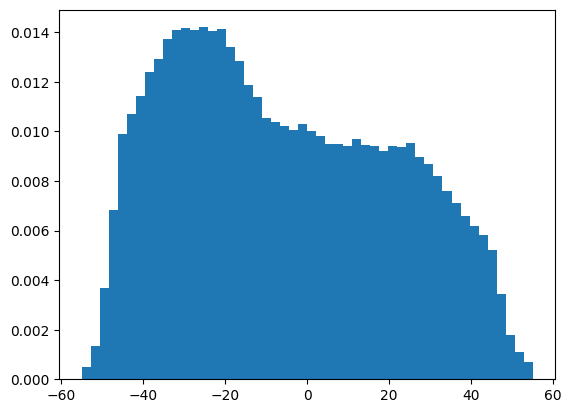

In [8]:
#let's start with hit direction and then see if we can do launch angle|hit direction and/or launch_speed|hit_direction
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
plt.show()

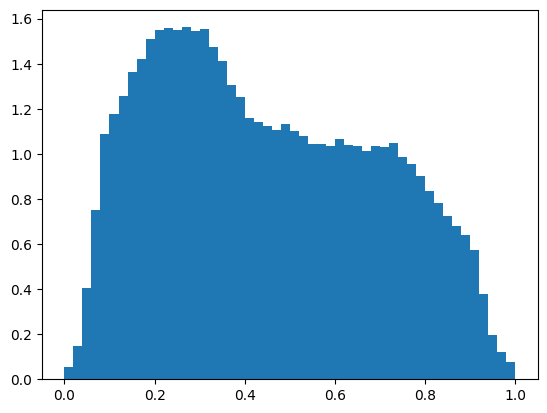

In [9]:
#it's a little bit multimodal, but given that it is bounded on either side, a beta distribution on a scaled and shifted hit direction may work
plt.hist((all_data.hit_direction.values + 55)/110, bins = 50, density = True)
plt.show()

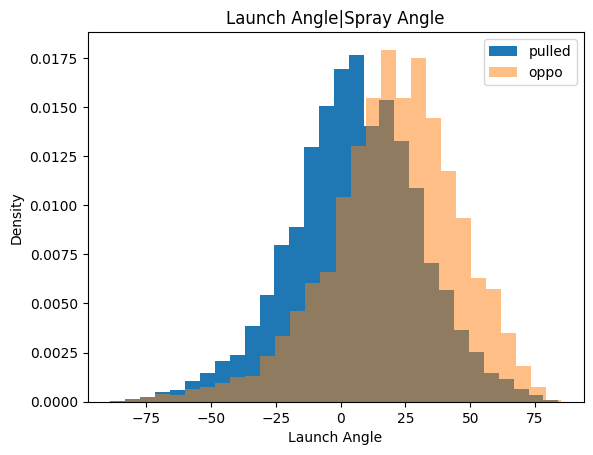

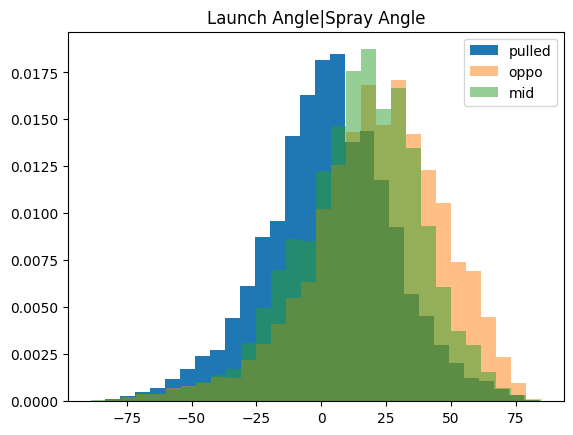

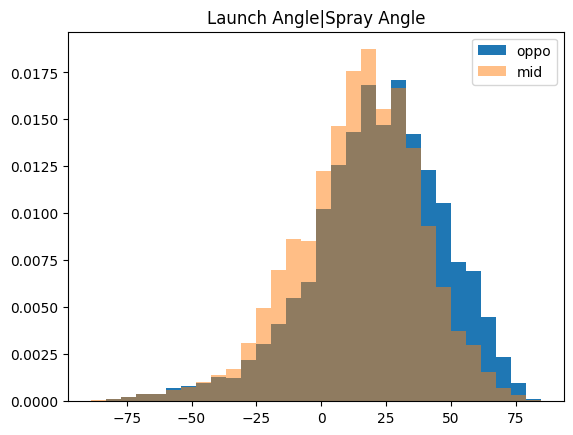

In [10]:
#plot
plt.hist(all_data.loc[all_data.hit_direction <= 0].launch_angle.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.hit_direction > 0].launch_angle.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.legend()
plt.title('Launch Angle|Spray Angle')
plt.ylabel('Density')
plt.xlabel('Launch Angle')
plt.show()

plt.hist(all_data.loc[all_data.hit_direction <= -15].launch_angle.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.hit_direction > 15].launch_angle.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.hist(all_data.loc[(all_data.hit_direction <= 15) & (all_data.hit_direction > -15)].launch_angle.values, density = True, bins = 30, label = 'mid', alpha = 0.5)
plt.legend()
plt.title('Launch Angle|Spray Angle')
plt.show()

plt.hist(all_data.loc[all_data.hit_direction > 15].launch_angle.values, density = True, bins = 30, label = 'oppo')
plt.hist(all_data.loc[(all_data.hit_direction <= 15) & (all_data.hit_direction > -15)].launch_angle.values, density = True, bins = 30, label = 'mid', alpha = 0.5)
plt.legend()
plt.title('Launch Angle|Spray Angle')
plt.show()

Couple things to note: first launch angle does not appear to be independent of hit direction. As hit direction becomes more oppo (increases), the distribution of launch angle tends to increase. Second, the distribution of launch angle is fairly normally distributed. So I think the way to go is to fit separate normal launch angle distributions for pulled and oppo balls or maybe pulled, middle, and oppo balls.

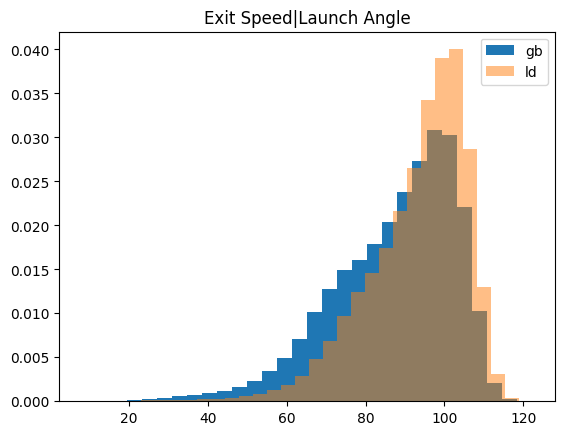

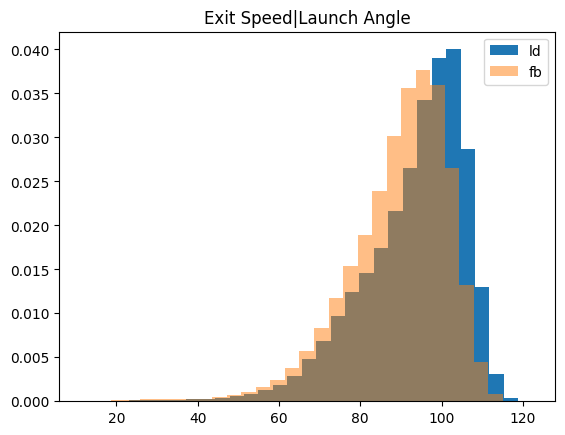

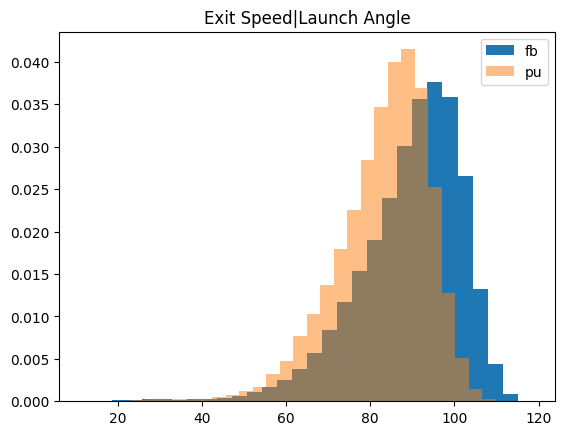

In [11]:
#see if exit speed is independent of launch angle
all_data['la_type'] = 0 #la_type is going to be 0,1,2,3 corresponding to groundball, line drive, flyball, popup
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <=25), 'la_type'] = 1
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <=50), 'la_type'] = 2
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3
plt.hist(all_data.loc[all_data.la_type == 0].launch_speed.values, density = True, bins = 30, label = 'gb')
plt.hist(all_data.loc[all_data.la_type == 1].launch_speed.values, density = True, bins = 30, label = 'ld', alpha = 0.5)
plt.legend()
plt.title('Exit Speed|Launch Angle')
plt.show()
plt.hist(all_data.loc[all_data.la_type == 1].launch_speed.values, density = True, bins = 30, label = 'ld')
plt.hist(all_data.loc[all_data.la_type == 2].launch_speed.values, density = True, bins = 30, label = 'fb',alpha = 0.5)
plt.legend()
plt.title('Exit Speed|Launch Angle')
plt.show()
plt.hist(all_data.loc[all_data.la_type == 2].launch_speed.values, density = True, bins = 30, label = 'fb')
plt.hist(all_data.loc[all_data.la_type == 3].launch_speed.values, density = True, bins = 30, label = 'pu',alpha = 0.5)
plt.legend()
plt.title('Exit Speed|Launch Angle')
plt.show()

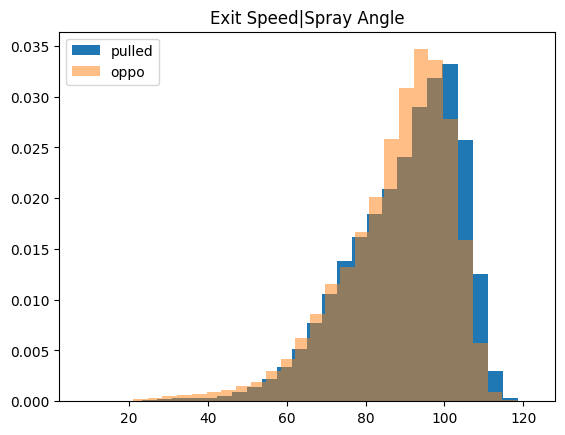

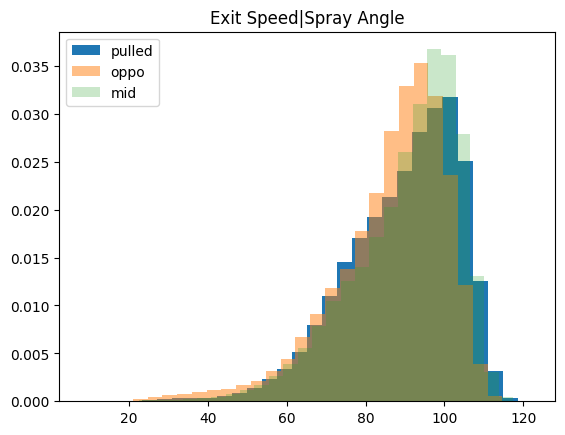

In [12]:
#see if exit speed is independent of spray angle
plt.hist(all_data.loc[all_data.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.legend()
plt.title('Exit Speed|Spray Angle')
plt.show()

plt.hist(all_data.loc[all_data.hit_direction <= -15].launch_speed.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.hit_direction > 15].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.hist(all_data.loc[(all_data.hit_direction <= 15) & (all_data.hit_direction > -15)].launch_speed.values, density = True, bins = 30, label = 'mid', alpha = 0.25)
plt.legend()
plt.title('Exit Speed|Spray Angle')
plt.show()

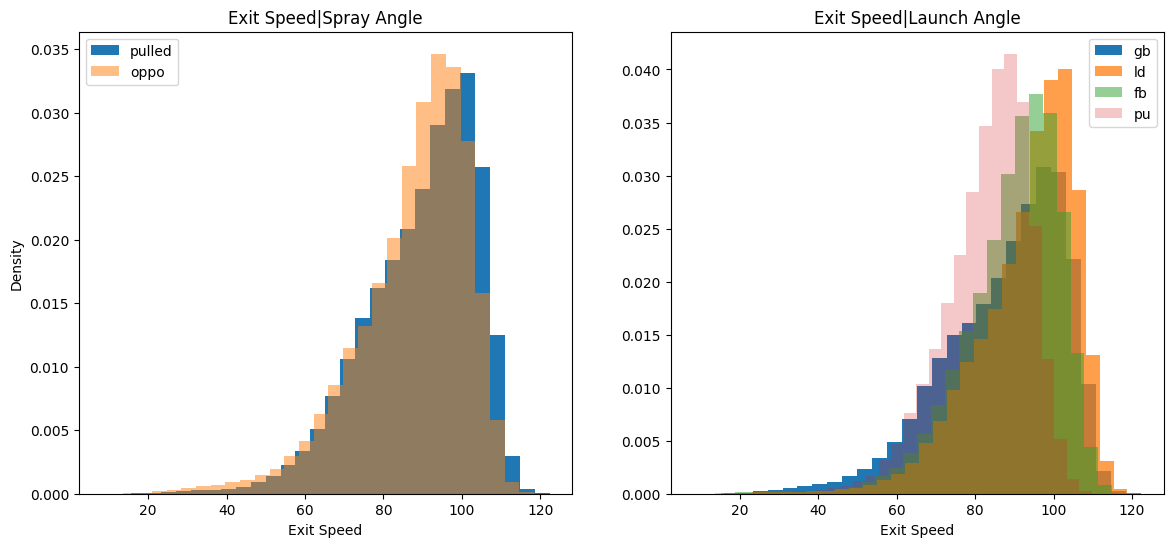

In [13]:
#see if exit speed is independent of launch angle
fig = plt.figure(figsize = (14,6))
ax1 = plt.subplot(121)
ax1.hist(all_data.loc[all_data.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax1.hist(all_data.loc[all_data.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax1.legend()
ax1.set_title('Exit Speed|Spray Angle')
ax1.set_xlabel('Exit Speed')
ax1.set_ylabel('Density')
ax2 = plt.subplot(122)
ax2.hist(all_data.loc[all_data.la_type == 0].launch_speed.values, density = True, bins = 30, label = 'gb')
ax2.hist(all_data.loc[all_data.la_type == 1].launch_speed.values, density = True, bins = 30, label = 'ld', alpha = 0.75)
ax2.hist(all_data.loc[all_data.la_type == 2].launch_speed.values, density = True, bins = 30, label = 'fb',alpha = 0.5)
ax2.hist(all_data.loc[all_data.la_type == 3].launch_speed.values, density = True, bins = 30, label = 'pu',alpha = 0.25)
ax2.legend()
ax2.set_title('Exit Speed|Launch Angle')
ax2.set_xlabel('Exit Speed')
plt.show()

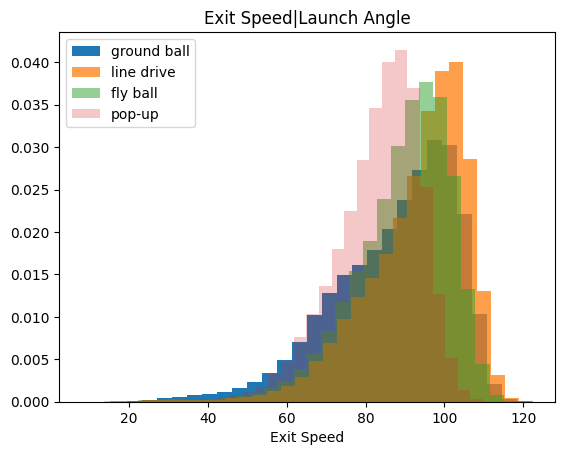

In [14]:
plt.hist(all_data.loc[all_data.la_type == 0].launch_speed.values, density = True, bins = 30, label = 'ground ball')
plt.hist(all_data.loc[all_data.la_type == 1].launch_speed.values, density = True, bins = 30, label = 'line drive', alpha = 0.75)
plt.hist(all_data.loc[all_data.la_type == 2].launch_speed.values, density = True, bins = 30, label = 'fly ball',alpha = 0.5)
plt.hist(all_data.loc[all_data.la_type == 3].launch_speed.values, density = True, bins = 30, label = 'pop-up',alpha = 0.25)
plt.legend()
plt.title('Exit Speed|Launch Angle')
plt.xlabel('Exit Speed')
plt.show()

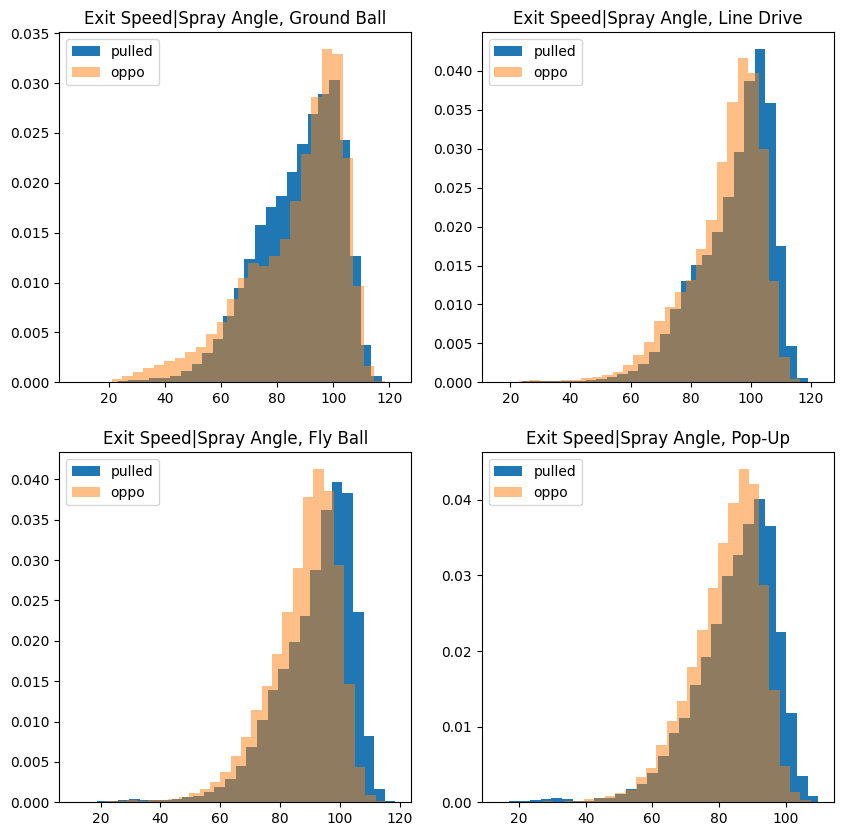

In [ ]:

#see if exit speed is independent of spray angle conditioned on launch angle
plt.figure(figsize=(10,10))
gb = all_data.loc[all_data.la_type == 0]
ax1 = plt.subplot(221)
ax1.hist(gb.loc[gb.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax1.hist(gb.loc[gb.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax1.legend()
ax1.set_title('Exit Speed|Spray Angle, Ground Ball')

ld = all_data.loc[all_data.la_type == 1]
ax2 = plt.subplot(222)
ax2.hist(ld.loc[ld.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax2.hist(ld.loc[ld.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax2.legend()
ax2.set_title('Exit Speed|Spray Angle, Line Drive')

fb = all_data.loc[all_data.la_type == 2]
ax3 = plt.subplot(223)
ax3.hist(fb.loc[fb.hit_direction <= 0].launch_speed.values, density = True, bins = 30,  label = 'pulled')
ax3.hist(fb.loc[fb.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax3.legend()
ax3.set_title('Exit Speed|Spray Angle, Fly Ball')

pu = all_data.loc[all_data.la_type == 3]
ax4 = plt.subplot(224)
ax4.hist(pu.loc[pu.hit_direction <= 0].launch_speed.values, density = True, bins = 30, label = 'pulled')
ax4.hist(pu.loc[pu.hit_direction > 0].launch_speed.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax4.legend()
ax4.set_title('Exit Speed|Spray Angle, Pop-Up')
plt.show()

Exit speed definitely seems to be dependent on launch angle. I think it is reasonable to assume that it is independent of hit direction though, especially since launch angle isn't independent of hit direction, so hopefully that small difference in exit speed between pulled and oppo balls will get picked up when we sample popups to the opposite field that will have weaker exit speeds.

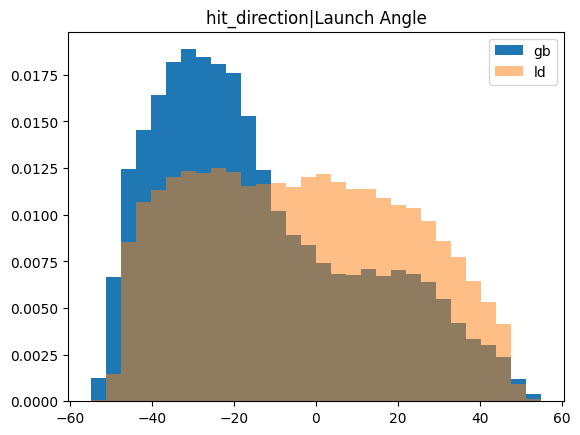

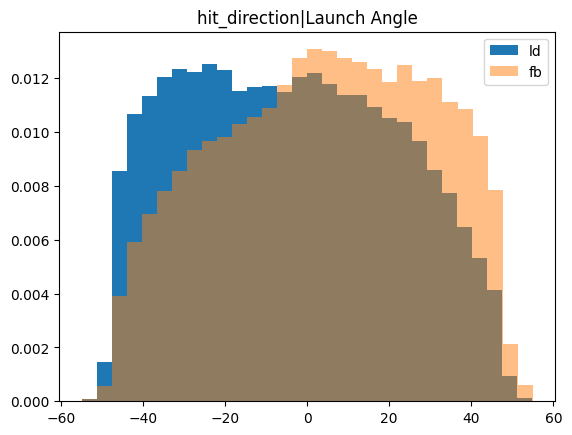

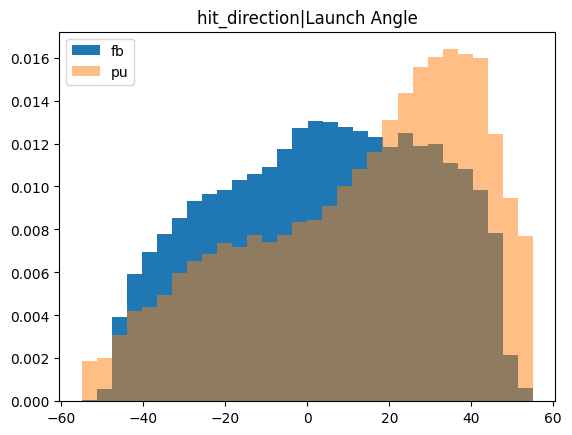

In [ ]:
#if we break down hit direction by launch angle, does it look more like a beta dist
plt.hist(all_data.loc[all_data.la_type == 0].hit_direction.values, density = True, bins = 30, label = 'gb')
plt.hist(all_data.loc[all_data.la_type == 1].hit_direction.values, density = True, bins = 30, label = 'ld', alpha = 0.5)
plt.legend()
plt.title('hit_direction|Launch Angle')
plt.show()
plt.hist(all_data.loc[all_data.la_type == 1].hit_direction.values, density = True, bins = 30, label = 'ld')
plt.hist(all_data.loc[all_data.la_type == 2].hit_direction.values, density = True, bins = 30, label = 'fb',alpha = 0.5)
plt.legend()
plt.title('hit_direction|Launch Angle')
plt.show()
plt.hist(all_data.loc[all_data.la_type == 2].hit_direction.values, density = True, bins = 30, label = 'fb')
plt.hist(all_data.loc[all_data.la_type == 3].hit_direction.values, density = True, bins = 30, label = 'pu',alpha = 0.5)
plt.legend()
plt.title('hit_direction|Launch Angle')
plt.show()

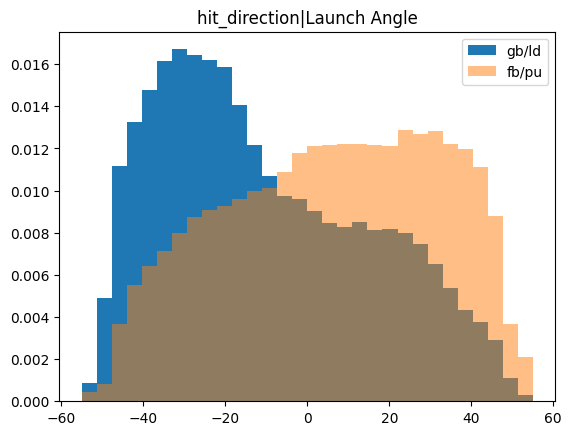

In [ ]:
plt.hist(all_data.loc[all_data.la_type < 2].hit_direction.values, density = True, bins = 30, label = 'gb/ld')
plt.hist(all_data.loc[all_data.la_type >= 2].hit_direction.values, density = True, bins = 30, label = 'fb/pu',alpha = 0.5)
plt.legend()
plt.title('hit_direction|Launch Angle')
plt.show()

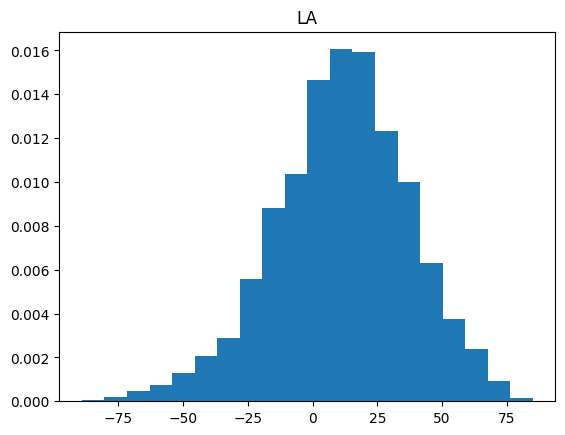

In [ ]:
#could we do launch angle on it's own
plt.hist(all_data.launch_angle.values, density = True, bins = 20)
plt.title('LA')
plt.show()

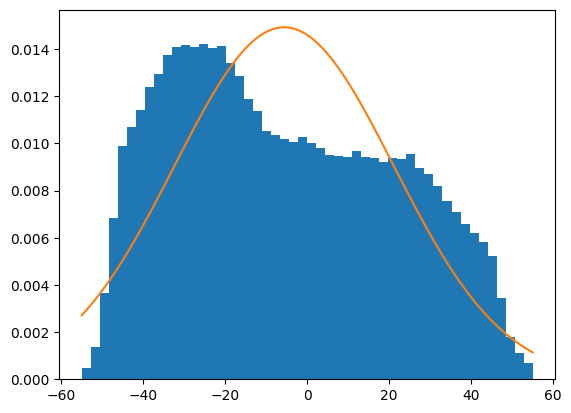

In [ ]:
#would a mixture model work better for hit direction?
gmm1 = GaussianMixture(1).fit(all_data.hit_direction.values.reshape((-1,1)))
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
x = np.linspace(-55,55, 100)
plt.plot(x, np.exp(gmm1.score_samples(x.reshape((-1,1)))), '-')
plt.show()

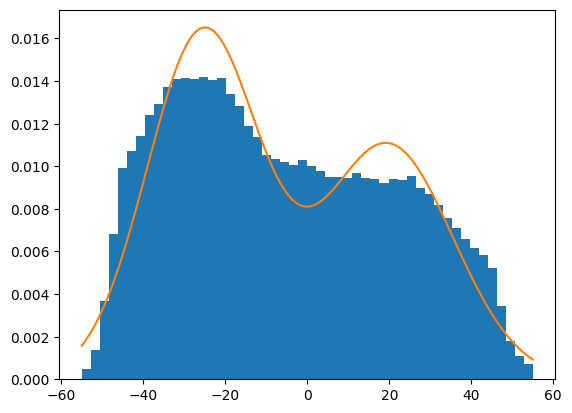

In [ ]:
gmm2 = GaussianMixture(2).fit(all_data.hit_direction.values.reshape((-1,1)))
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
x = np.linspace(-55,55, 100)
plt.plot(x, np.exp(gmm2.score_samples(x.reshape((-1,1)))), '-')
plt.show()

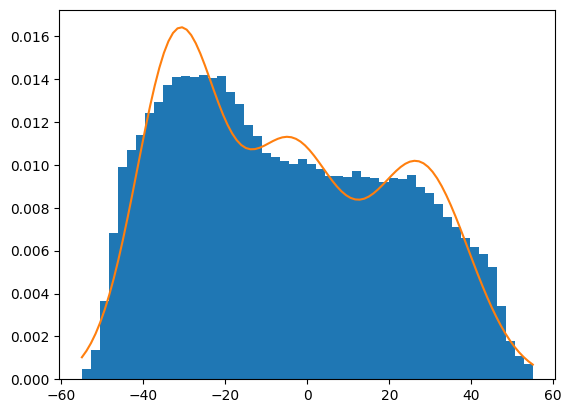

In [ ]:
gmm3 = GaussianMixture(3).fit(all_data.hit_direction.values.reshape((-1,1)))
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
x = np.linspace(-55,55, 100)
plt.plot(x, np.exp(gmm3.score_samples(x.reshape((-1,1)))), '-')
plt.show()

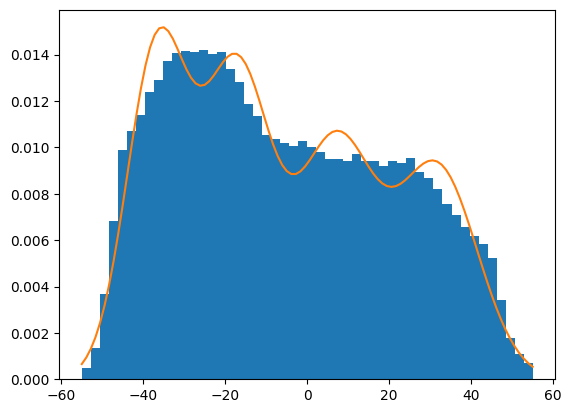

In [ ]:
gmm4 = GaussianMixture(4).fit(all_data.hit_direction.values.reshape((-1,1)))
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
x = np.linspace(-55,55, 100)
plt.plot(x, np.exp(gmm4.score_samples(x.reshape((-1,1)))), '-')
plt.show()

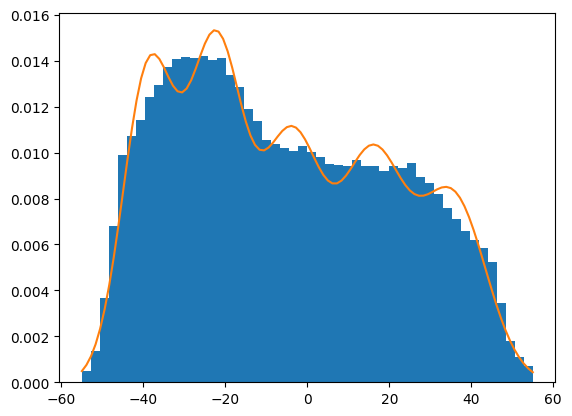

In [ ]:
gmm5 = GaussianMixture(5).fit(all_data.hit_direction.values.reshape((-1,1)))
plt.hist(all_data.hit_direction.values, density = True, bins = 50)
x = np.linspace(-55,55, 100)
plt.plot(x, np.exp(gmm5.score_samples(x.reshape((-1,1)))), '-')
plt.show()

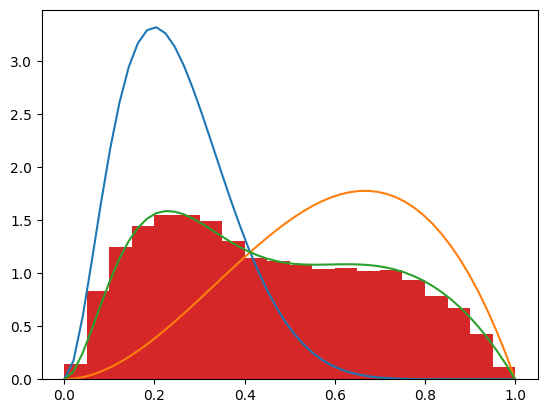

In [ ]:
#try a mixture of betas: trial and error since there isn't a bmm option in sklearn.
all_data['hd'] = (all_data.hit_direction + 55)/110
x = np.linspace(0,1)
plt.plot(x, beta(a = 3, b=9).pdf(x), '-')
plt.plot(x, beta(a=3,b=2).pdf(x))
plt.plot(x, .4*beta(a = 3, b=9).pdf(x)+ 0.6*beta(a=3,b=2).pdf(x), '-')
plt.hist(all_data.hd.values, density = True, bins = 20)
plt.show()

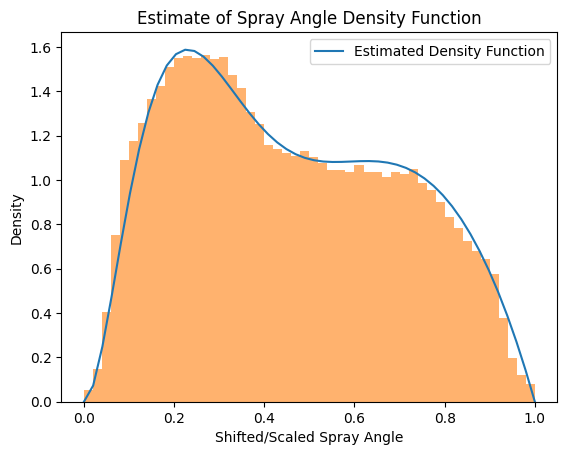

In [ ]:
plt.plot(x, .4*beta(a = 3, b=9).pdf(x)+ 0.6*beta(a=3,b=2).pdf(x), '-', label = 'Estimated Density Function')
plt.hist(all_data.hd.values, density = True, bins = 50, alpha = 0.6)
plt.legend()
plt.xlabel('Shifted/Scaled Spray Angle')
plt.ylabel('Density')
plt.title('Estimate of Spray Angle Density Function')
plt.show()